#### Carregando biblioteca de funções Turing

In [6]:
%run -i '/home/hadoop/.Turing/TuringAllFunctions.py'

#### Parêmtros do Projeto

In [7]:
#------ Modo Manual -----------------
nm_bucket = 'turing-bkt-treinamentos'
id_projeto = '350002'
nm_file = 'OOS01_TITANIC_VALID.csv'
id_empresa = '1022'
targetname = 'Survived'
abt_delimiter = ','
pct_amt = 1

In [10]:
################### Não alterar este parágrafo #####################################
#---------- Gerando Credenciais para Acesso Seguro ---------------------------------
id_modelo = id_projeto
schema = 'EMP_'+ id_empresa +'_Proj_'+ id_projeto
S3fs,S3session,S3client,S3resource = TuringUsersCredentialsControl(id_empresa)
schema_rds = 'EMP_'+id_empresa+'_Proj_'+id_projeto
mysq_conn,engine = TuringRDSManagementConn(id_empresa,schema_rds,turing_adm = 'N')
path_s3_wfile = 's3://'+nm_bucket+'/Projetos/'+'Projeto_'+id_projeto+'/Modelo_Id_'+id_projeto+'/Modeltrain/'
s3_path = path_s3_wfile
####################################################################################

#### Lendo tabela de validação que será escorada

In [8]:
# Lendo tabela de desenvolvimento original do bucket da POC
path_file = 'Projetos/SCORE_BATCH/'+str(nm_file)
df_00 = TuringReadS3CSVFile(nm_bucket,path_file,sep=',')
df_00.shape

(268, 12)

#### Verificando qual modelo está implantado para este projeto
    - Caso queira trocar o modelo volte ao Timeline Turing e implante um novo modelo desejado
    


In [15]:
modelos_implantados = pd.read_sql('SELECT lower(nm_modelo) as nm_modelo FROM model_deployment_tabaux where deploy_def ="S" limit 1', con=mysq_conn)
lista_modelos_implantados = modelos_implantados['nm_modelo']
nm_modelo = str(lista_modelos_implantados[0])
modelo = lista_modelos_implantados[0]
modelo_mem = TuringLoadModelFromS3(S3client,nm_bucket,id_modelo,id_projeto,nm_modelo)
modelo

u'logreg'

#### Verificando parametrização do modelo implantado

In [17]:
modelo_mem

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### Escorando tabela de validação

In [19]:
valid_score = TuringScoreBatchLab(df_00,nm_bucket,id_projeto,nm_file,id_empresa,targetname,abt_delimiter=',',pct_amt = 1)
valid_score.shape

(268, 11)

In [20]:
valid_score.head()

,Fare,Age,Pclass,TGD_Sex_female,TGD_Sex_male,P_Target_0,P_Target_1,C_Target,PassengerId,PK_DATREF_XX,PK_DATVER_XX
0,-0.373297,-2.184731e-15,0.848448,0,1,0.879856,0.120144,0,496,20190514,2019-05-14 13:23:25
1,-0.516566,-2.184731e-15,0.848448,0,1,0.879746,0.120254,0,649,20190514,2019-05-14 13:23:25
2,-0.069128,-1.761465e+00,0.848448,0,1,0.780491,0.219509,0,279,20190514,2019-05-14 13:23:25
3,2.365514,-2.184731e-15,-1.532556,1,0,0.098400,0.901600,1,32,20190514,2019-05-14 13:23:25
4,-0.356965,-7.036060e-02,0.848448,1,0,0.383464,0.616536,1,256,20190514,2019-05-14 13:23:25


### Comparativo entre scores de 4 tecnicas:
 * Gradient Boosting
 * XGBoost
 * Random Forest
 * Regressão Logística
 

In [24]:
score_compare_valida = TuringScoringBatch(id_empresa,id_projeto,df_00,ScoreML=1)

In [25]:
score_compare_valida.head()

,Fare,Age,Pclass,TGD_Sex_female,TGD_Sex_male,P_Target_0,P_Target_1,C_Target,P_Target_0_XGB,P_Target_1_XGB,...,C_Target_GB,P_Target_0_RF,P_Target_1_RF,C_Target_RF,P_Target_0_RL,P_Target_1_RL,C_Target_RL,PassengerId,PK_DATREF_XX,PK_DATVER_XX
0,-0.373297,-2.184731e-15,0.848448,0,1,0.879856,0.120144,0,0.724042,0.275958,...,0,0.763273,0.236727,0,0.879856,0.120144,0,496,20190514,2019-05-14 13:29:11
1,-0.516566,-2.184731e-15,0.848448,0,1,0.879746,0.120254,0,0.727272,0.272728,...,0,0.931052,0.068948,0,0.879746,0.120254,0,649,20190514,2019-05-14 13:29:11
2,-0.069128,-1.761465e+00,0.848448,0,1,0.780491,0.219509,0,0.754238,0.245762,...,0,0.918117,0.081883,0,0.780491,0.219509,0,279,20190514,2019-05-14 13:29:11
3,2.365514,-2.184731e-15,-1.532556,1,0,0.098400,0.901600,1,0.210794,0.789206,...,0,0.122801,0.877199,1,0.098400,0.901600,1,32,20190514,2019-05-14 13:29:11
4,-0.356965,-7.036060e-02,0.848448,1,0,0.383464,0.616536,1,0.372322,0.627678,...,0,0.281502,0.718498,1,0.383464,0.616536,1,256,20190514,2019-05-14 13:29:11


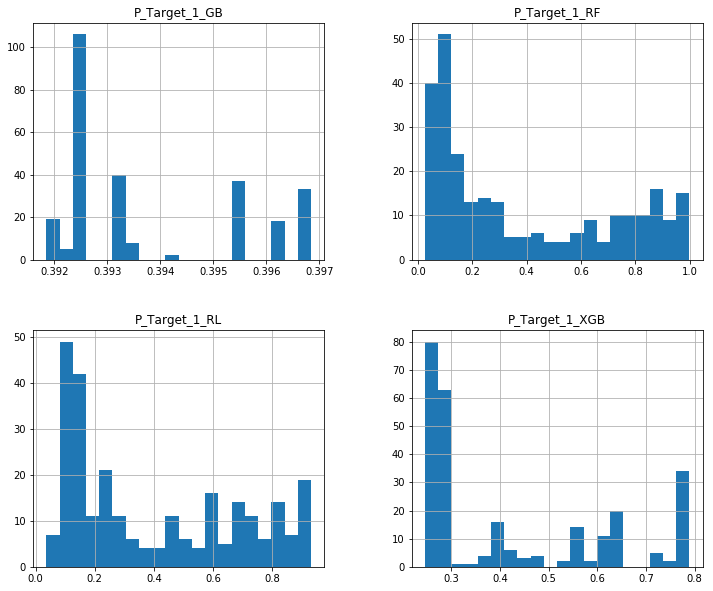

In [29]:
TuringHistogram(score_compare_valida[['P_Target_1_XGB','P_Target_1_RL','P_Target_1_RF','P_Target_1_GB']]) 

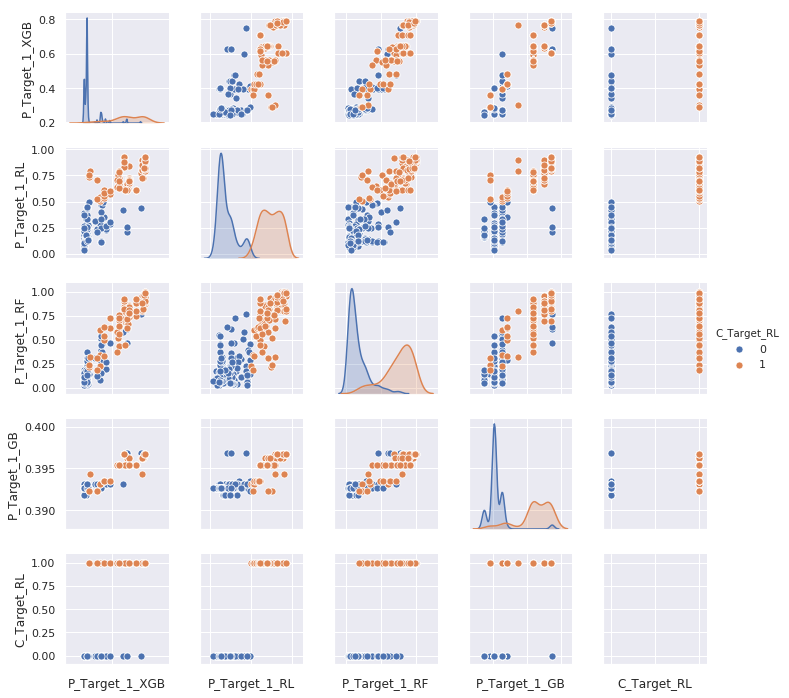

In [32]:
TuringDVPairPlot(score_compare_valida[['P_Target_1_XGB','P_Target_1_RL','P_Target_1_RF','P_Target_1_GB','C_Target_RL']],targetname='C_Target_RL',sizegraph=2,plot_s = 50)

'TuringNormalProbPlot'

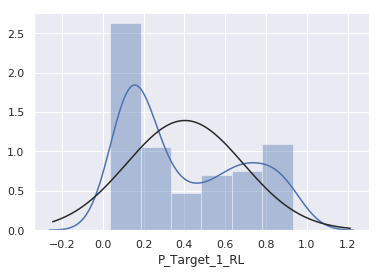

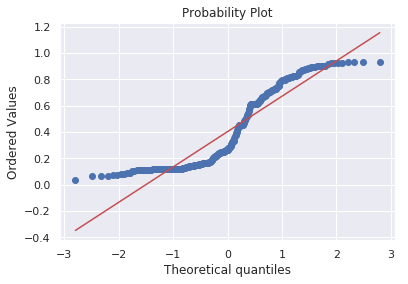

In [33]:
TuringNormalProbPlot(score_compare_valida,'P_Target_1_RL')

'TuringNormalProbPlot'

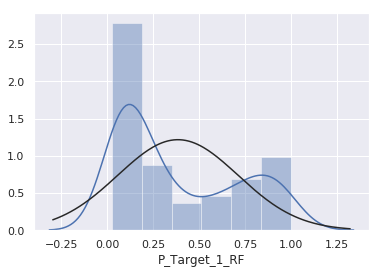

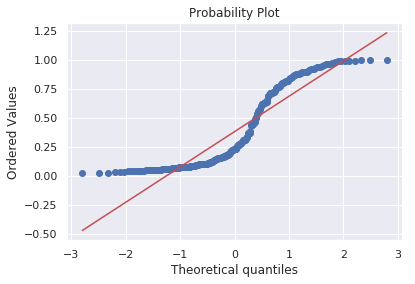

In [37]:
TuringNormalProbPlot(score_compare_valida,'P_Target_1_RF')

#### Verificando a ordenação do score gerado pelo modelo implantado

In [40]:
# Lendo tabela de desenvolvimento original do bucket da POC
path_file = 'Projetos/'+'Projeto_'+id_projeto+'/Modelo_Id_'+id_projeto+'/Modeltrain/'+'dbi_ordenacao.csv'
df_ord = TuringReadS3CSVFile(nm_bucket,path_file,sep=',')
df_ord.head(10)

,Unnamed: 0,id_ranks,tx_evento,qt_rank
0,0,0,0.963636,55
1,1,1,0.896552,58
2,2,2,0.606061,33
3,3,3,0.603175,63
4,4,4,0.300000,10
5,5,5,0.414634,41
6,6,6,0.378378,37
7,7,7,0.194030,67
8,8,8,0.128205,117
9,9,9,0.119718,142


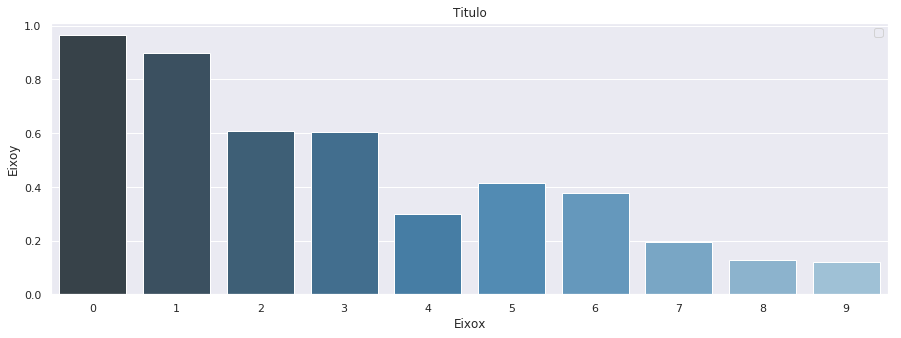

'TuringLinePlot'

In [57]:
TuringBarPlot(df_ord,'id_ranks','tx_evento',5,15,'Eixox','Eixoy','Titulo','')